In [28]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from shapely.geometry import box
from rasterio.features import rasterize
from skimage.util import view_as_windows
from tqdm import tqdm

# ---------- CONFIGURATION ----------
NAIP_PATH = ""
NDSM_PATH = ""
INTENSITY_PATH = ""
ROAD_VECTOR_PATH = ""

OUTPUT_IMG_DIR = ""
OUTPUT_MASK_DIR = ""

PATCH_SIZE = 64
STRIDE = 64
# ----------------------------------

def read_and_resample(src_path, target_meta):
    """Reads a raster and resamples to target metadata"""
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(src.count, target_meta["height"], target_meta["width"]),
            resampling=Resampling.bilinear,
        )
        return data


def rasterize_roads(gdf, out_shape, transform):
    shapes = ((geom, 1) for geom in gdf.geometry)
    mask = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )
    return mask


def save_patches(image, mask, output_img_dir, output_mask_dir, patch_size, stride):
    """Save image/mask patches"""
    img_patches = view_as_windows(image, (image.shape[0], patch_size, patch_size), step=stride)
    mask_patches = view_as_windows(mask, (patch_size, patch_size), step=stride)

    patch_id = 0
    for i in range(img_patches.shape[1]):
        for j in range(img_patches.shape[2]):
            img_patch = img_patches[0, i, j]
            mask_patch = mask_patches[i, j]

            np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), img_patch)
            np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), mask_patch)
            patch_id += 1


def main():
    os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
    os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

    print("Loading NAIP image...")
    with rasterio.open(NAIP_PATH) as naip_src:
        naip_data = naip_src.read() / 255.0  # Normalize NAIP
        meta = naip_src.meta
        transform = naip_src.transform
        crs = naip_src.crs
        width, height = naip_src.width, naip_src.height

    print("Loading and resampling LiDAR rasters...")
    ndsm = read_and_resample(NDSM_PATH, meta)[0]  # First band
    ndsm = (ndsm - ndsm.min()) / (ndsm.max() - ndsm.min() + 1e-6)

    intensity = read_and_resample(INTENSITY_PATH, meta)[0]
    intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min() + 1e-6)

    print("Stacking all bands...")
    full_stack = np.concatenate([naip_data, ndsm[np.newaxis, :, :], intensity[np.newaxis, :, :]], axis=0)

    print("Rasterizing roads...")
    roads = gpd.read_file(ROAD_VECTOR_PATH).to_crs(crs)
    mask = rasterize_roads(roads, out_shape=(height, width), transform=transform)

    print("Saving patches...")
    save_patches(full_stack, mask, OUTPUT_IMG_DIR, OUTPUT_MASK_DIR, PATCH_SIZE, STRIDE)

    print("✅ Preprocessing complete!")

In [29]:
main()

Loading NAIP image...
Loading and resampling LiDAR rasters...
Stacking all bands...
Rasterizing roads...
Saving patches...
✅ Preprocessing complete!


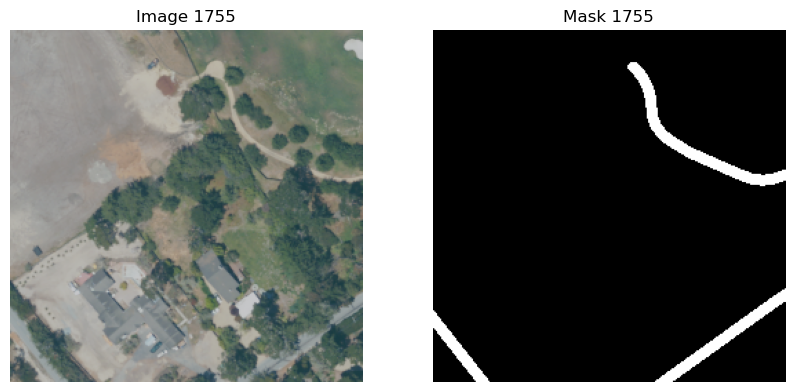

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define directories where images and masks are stored
OUTPUT_IMG_DIR = ""
OUTPUT_MASK_DIR = ""

def visualize_sample_images(num_samples=20):
    """Visualize a few random image and mask pairs to inspect road presence"""
    
    image_files = sorted(os.listdir(OUTPUT_IMG_DIR))
    mask_files = sorted(os.listdir(OUTPUT_MASK_DIR))

    valid_image_mask_pairs = []
    for img_file, mask_file in zip(image_files, mask_files):
        mask = np.load(os.path.join(OUTPUT_MASK_DIR, mask_file))
        if np.sum(mask) > 0:  # Check if the mask has roads
            valid_image_mask_pairs.append((img_file, mask_file))

    num_samples = min(num_samples, len(valid_image_mask_pairs))

    sampled_pairs = np.random.choice(len(valid_image_mask_pairs), num_samples, replace=False)

    for i in sampled_pairs:
        img_file, mask_file = valid_image_mask_pairs[i]
        img_path = os.path.join(OUTPUT_IMG_DIR, img_file)
        mask_path = os.path.join(OUTPUT_MASK_DIR, mask_file)

        image = np.load(img_path)
        mask = np.load(mask_path)

        if len(mask.shape) > 2:
            # If it's multi-channel, select the first channel (typically the mask should be single-channel)
            mask = mask[0]

        # Display the image and mask side-by-side
        plt.figure(figsize=(10, 5))
        

        plt.subplot(1, 2, 1)
        img_to_show = image[:3, :, :]  # Show only the first 3 channels (RGB-like)
        plt.imshow(np.transpose(img_to_show, (1, 2, 0)))  # Convert (C, H, W) to (H, W, C)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

        # Plot the mask (ensure it's a 2D array)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')  # Show the mask (should be 2D)
        plt.title(f"Mask {i + 1}")
        plt.axis('off')
        plt.show()

# Call the function to visualize 1 sample
visualize_sample_images(num_samples=1)


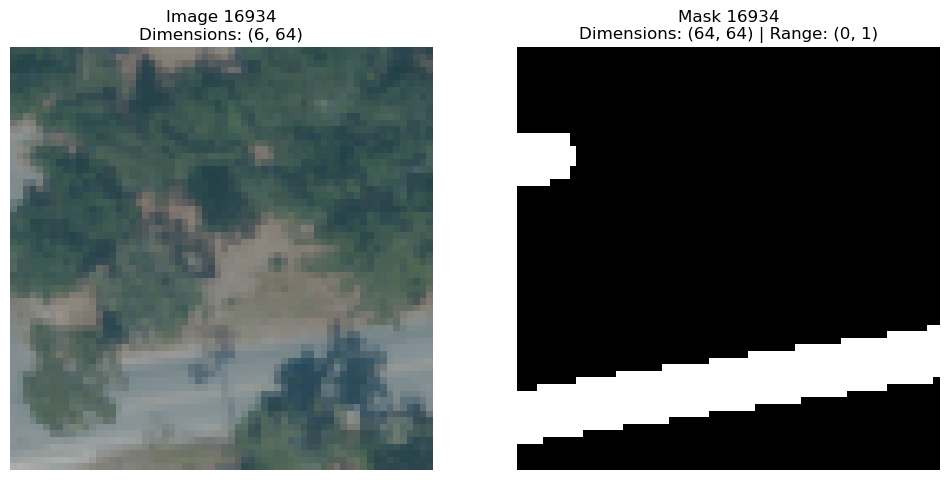

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define directories where images and masks are stored
OUTPUT_IMG_DIR = ""
OUTPUT_MASK_DIR = ""

def visualize_sample_images(num_samples=20):
    """Visualize a few random image and mask pairs to inspect road presence"""
    
    # Get list of image and mask files
    image_files = sorted(os.listdir(OUTPUT_IMG_DIR))
    mask_files = sorted(os.listdir(OUTPUT_MASK_DIR))

    # Filter out masks with no roads
    valid_image_mask_pairs = []
    for img_file, mask_file in zip(image_files, mask_files):
        mask = np.load(os.path.join(OUTPUT_MASK_DIR, mask_file))
        if np.sum(mask) > 0:  # Check if the mask has roads
            valid_image_mask_pairs.append((img_file, mask_file))

    # Ensure we don't try to access more files than available
    num_samples = min(num_samples, len(valid_image_mask_pairs))

    # Sample randomly from valid pairs
    sampled_pairs = np.random.choice(len(valid_image_mask_pairs), num_samples, replace=False)

    for i in sampled_pairs:
        img_file, mask_file = valid_image_mask_pairs[i]
        img_path = os.path.join(OUTPUT_IMG_DIR, img_file)
        mask_path = os.path.join(OUTPUT_MASK_DIR, mask_file)

        # Load the image and mask
        image = np.load(img_path)
        mask = np.load(mask_path)

        # Check the shape of the mask (it might have extra dimensions like channels)
        if len(mask.shape) > 2:
            # If it's multi-channel, select the first channel (typically the mask should be single-channel)
            mask = mask[0]

        # Get image and mask dimensions
        img_shape = image.shape
        mask_shape = mask.shape

        # Get the range of pixel values in the mask
        mask_min, mask_max = np.min(mask), np.max(mask)

        # Display the image and mask side-by-side
        plt.figure(figsize=(12, 6))
        
        # Plot the image (showing the first 3 channels if it's a multi-channel image)
        plt.subplot(1, 2, 1)
        img_to_show = image[:3, :, :]  # Show only the first 3 channels (RGB-like)
        plt.imshow(np.transpose(img_to_show, (1, 2, 0)))  # Convert (C, H, W) to (H, W, C) for visualization
        plt.title(f"Image {i + 1}\nDimensions: {img_shape[:2]}")  # Show dimensions of the image
        plt.axis('off')

        # Plot the mask (ensure it's a 2D array)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')  # Show the mask (should be 2D)
        plt.title(f"Mask {i + 1}\nDimensions: {mask_shape} | Range: ({mask_min}, {mask_max})")  # Show mask info
        plt.axis('off')

        # Show the plot
        plt.show()

# Call the function to visualize 1 sample
visualize_sample_images(num_samples=1)


In [3]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from shapely.geometry import box
from rasterio.features import rasterize
from skimage.util import view_as_windows
from skimage.transform import rotate, rescale
from tqdm import tqdm
import random

# ---------- CONFIGURATION ----------
NAIP_PATH = ""
NDSM_PATH = ""
INTENSITY_PATH = ""
ROAD_VECTOR_PATH = ""
OUTPUT_IMG_DIR = ""
OUTPUT_MASK_DIR = ""
PATCH_SIZE = 128
STRIDE = 128

# Augmentation settings
AUGMENT = True
# Define probability for each augmentation
AUG_PROBS = {
    'flip_h': 0.5,     # Horizontal flip probability
    'flip_v': 0.5,     # Vertical flip probability
    'rotate': 0.3,     # Rotation probability
    'scale': 0.2,      # Scaling probability
    'brightness': 0.3  # Brightness adjustment probability
}
# ----------------------------------

def read_and_resample(src_path, target_meta):
    """Reads a raster and resamples to target metadata"""
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(src.count, target_meta["height"], target_meta["width"]),
            resampling=Resampling.bilinear,
        )
    return data

def rasterize_roads(gdf, out_shape, transform):
    """Rasterizes road polygons into a binary mask"""
    shapes = ((geom, 1) for geom in gdf.geometry)
    mask = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )
    return mask

def augment_patch(img_patch, mask_patch):
    """Apply augmentations to image/mask pairs"""
    # Create a list to store the augmented patches
    augmented_imgs = [img_patch]
    augmented_masks = [mask_patch]
    
    # Get the number of channels for proper reshaping
    n_channels = img_patch.shape[0]
    
    # 1. Horizontal flip
    if random.random() < AUG_PROBS['flip_h']:
        flipped_img = img_patch.copy()
        for c in range(n_channels):
            flipped_img[c] = np.fliplr(img_patch[c])
        flipped_mask = np.fliplr(mask_patch)
        augmented_imgs.append(flipped_img)
        augmented_masks.append(flipped_mask)
    
    # 2. Vertical flip
    if random.random() < AUG_PROBS['flip_v']:
        flipped_img = img_patch.copy()
        for c in range(n_channels):
            flipped_img[c] = np.flipud(img_patch[c])
        flipped_mask = np.flipud(mask_patch)
        augmented_imgs.append(flipped_img)
        augmented_masks.append(flipped_mask)
    
    # 3. Rotation (90, 180, 270 degrees)
    if random.random() < AUG_PROBS['rotate']:
        angle = random.choice([90, 180, 270])
        rotated_img = np.zeros_like(img_patch)
        for c in range(n_channels):
            rotated_img[c] = rotate(img_patch[c], angle, preserve_range=True).astype(img_patch.dtype)
        rotated_mask = rotate(mask_patch, angle, preserve_range=True).astype(mask_patch.dtype)
        # Ensure binary mask
        rotated_mask = (rotated_mask > 0.5).astype(mask_patch.dtype)
        augmented_imgs.append(rotated_img)
        augmented_masks.append(rotated_mask)
    
    # 4. Brightness adjustment (for visual bands only)
    if random.random() < AUG_PROBS['brightness']:
        brightness_img = img_patch.copy()
        # Apply to first 4 bands (assuming NAIP RGB+NIR)
        brightness_factor = random.uniform(0.8, 1.2)
        for c in range(min(4, n_channels)):
            brightness_img[c] = np.clip(img_patch[c] * brightness_factor, 0, 1)
        augmented_imgs.append(brightness_img)
        augmented_masks.append(mask_patch)  # Mask doesn't change
    
    return augmented_imgs, augmented_masks

def save_patches(image, mask, output_img_dir, output_mask_dir, patch_size, stride):
    """Save image/mask patches with augmentation"""
    img_patches = view_as_windows(image, (image.shape[0], patch_size, patch_size), step=stride)
    mask_patches = view_as_windows(mask, (patch_size, patch_size), step=stride)
    
    patch_id = 0
    for i in tqdm(range(img_patches.shape[1]), desc="Processing patches"):
        for j in range(img_patches.shape[2]):
            img_patch = img_patches[0, i, j]
            mask_patch = mask_patches[i, j]
            
            # Check if patch contains any roads
            has_road = np.any(mask_patch > 0)
            
            # Save original patch
            np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), img_patch)
            np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), mask_patch)
            patch_id += 1
            
            # Apply augmentations if enabled and patch contains roads
            if AUGMENT and has_road:
                aug_imgs, aug_masks = augment_patch(img_patch, mask_patch)
                
                # Save augmented patches
                for k in range(1, len(aug_imgs)):  # Start from 1 as 0 is the original
                    np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), aug_imgs[k])
                    np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), aug_masks[k])
                    patch_id += 1

def main():
    os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
    os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
    
    print("Loading NAIP image...")
    with rasterio.open(NAIP_PATH) as naip_src:
        naip_data = naip_src.read() / 255.0  # Normalize NAIP
        meta = naip_src.meta
        transform = naip_src.transform
        crs = naip_src.crs
        width, height = naip_src.width, naip_src.height
    
    print("Loading and resampling LiDAR rasters...")
    ndsm = read_and_resample(NDSM_PATH, meta)[0]  # First band
    ndsm = (ndsm - ndsm.min()) / (ndsm.max() - ndsm.min() + 1e-6)
    intensity = read_and_resample(INTENSITY_PATH, meta)[0]
    intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min() + 1e-6)
    
    print("Stacking all bands...")
    full_stack = np.concatenate([naip_data, ndsm[np.newaxis, :, :], intensity[np.newaxis, :, :]], axis=0)
    
    print("Rasterizing roads...")
    roads = gpd.read_file(ROAD_VECTOR_PATH).to_crs(crs)
    road_mask = rasterize_roads(roads, out_shape=(height, width), transform=transform)
    
    print(f"Saving patches{' with augmentation' if AUGMENT else ''}...")
    save_patches(full_stack, road_mask, OUTPUT_IMG_DIR, OUTPUT_MASK_DIR, PATCH_SIZE, STRIDE)
    
    print("Preprocessing complete!")
    
    # Count files to show augmentation effect
    img_count = len([f for f in os.listdir(OUTPUT_IMG_DIR) if f.endswith('.npy')])
    print(f"Total patches generated: {img_count}")

if __name__ == "__main__":
    main()

Loading NAIP image...
Loading and resampling LiDAR rasters...
Stacking all bands...
Rasterizing roads...
Saving patches with augmentation...


Processing patches: 100%|██████████| 187/187 [03:35<00:00,  1.15s/it]


✅ Preprocessing complete!
Total patches generated: 146869


In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from shapely.geometry import box
from rasterio.features import rasterize
from skimage.util import view_as_windows
from skimage.transform import rotate, rescale
from tqdm import tqdm
import random

# ---------- CONFIGURATION ----------
NAIP_PATH = ""
NDSM_PATH = ""
INTENSITY_PATH = ""
ROAD_VECTOR_PATH = ""
OUTPUT_IMG_DIR = ""
OUTPUT_MASK_DIR = ""
PATCH_SIZE = 128
STRIDE = 128

# New buffer parameter (in units of the CRS, typically meters)
BUFFER_DISTANCE = 3.0  # Adjust this value as needed

# Augmentation settings
AUGMENT = True
# Define probability for each augmentation
AUG_PROBS = {
    'flip_h': 0.5,     # Horizontal flip probability
    'flip_v': 0.5,     # Vertical flip probability
    'rotate': 0.3,     # Rotation probability
    'scale': 0.2,      # Scaling probability
    'brightness': 0.3  # Brightness adjustment probability
}
# ----------------------------------

def read_and_resample(src_path, target_meta):
    """Reads a raster and resamples to target metadata"""
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(src.count, target_meta["height"], target_meta["width"]),
            resampling=Resampling.bilinear,
        )
    return data

def rasterize_roads(gdf, out_shape, transform, buffer_distance=0):
    """Rasterizes road polygons into a binary mask with optional buffer"""
    # Apply buffer if specified
    if buffer_distance > 0:
        gdf = gdf.copy()
        gdf['geometry'] = gdf.geometry.buffer(buffer_distance)
    
    shapes = ((geom, 1) for geom in gdf.geometry)
    mask = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )
    return mask

def augment_patch(img_patch, mask_patch):
    """Apply augmentations to image/mask pairs"""
    # Create a list to store the augmented patches
    augmented_imgs = [img_patch]
    augmented_masks = [mask_patch]
    
    # Get the number of channels for proper reshaping
    n_channels = img_patch.shape[0]
    
    # 1. Horizontal flip
    if random.random() < AUG_PROBS['flip_h']:
        flipped_img = img_patch.copy()
        for c in range(n_channels):
            flipped_img[c] = np.fliplr(img_patch[c])
        flipped_mask = np.fliplr(mask_patch)
        augmented_imgs.append(flipped_img)
        augmented_masks.append(flipped_mask)
    
    # 2. Vertical flip
    if random.random() < AUG_PROBS['flip_v']:
        flipped_img = img_patch.copy()
        for c in range(n_channels):
            flipped_img[c] = np.flipud(img_patch[c])
        flipped_mask = np.flipud(mask_patch)
        augmented_imgs.append(flipped_img)
        augmented_masks.append(flipped_mask)
    
    # 3. Rotation (90, 180, 270 degrees)
    if random.random() < AUG_PROBS['rotate']:
        angle = random.choice([90, 180, 270])
        rotated_img = np.zeros_like(img_patch)
        for c in range(n_channels):
            rotated_img[c] = rotate(img_patch[c], angle, preserve_range=True).astype(img_patch.dtype)
        rotated_mask = rotate(mask_patch, angle, preserve_range=True).astype(mask_patch.dtype)
        # Ensure binary mask
        rotated_mask = (rotated_mask > 0.5).astype(mask_patch.dtype)
        augmented_imgs.append(rotated_img)
        augmented_masks.append(rotated_mask)
    
    # 4. Brightness adjustment (for visual bands only)
    if random.random() < AUG_PROBS['brightness']:
        brightness_img = img_patch.copy()
        # Apply to first 4 bands (assuming NAIP RGB+NIR)
        brightness_factor = random.uniform(0.8, 1.2)
        for c in range(min(4, n_channels)):
            brightness_img[c] = np.clip(img_patch[c] * brightness_factor, 0, 1)
        augmented_imgs.append(brightness_img)
        augmented_masks.append(mask_patch)  # Mask doesn't change
    
    return augmented_imgs, augmented_masks

def save_patches(image, mask, output_img_dir, output_mask_dir, patch_size, stride):
    """Save image/mask patches with augmentation"""
    img_patches = view_as_windows(image, (image.shape[0], patch_size, patch_size), step=stride)
    mask_patches = view_as_windows(mask, (patch_size, patch_size), step=stride)
    
    patch_id = 0
    for i in tqdm(range(img_patches.shape[1]), desc="Processing patches"):
        for j in range(img_patches.shape[2]):
            img_patch = img_patches[0, i, j]
            mask_patch = mask_patches[i, j]
            
            # Check if patch contains any roads
            has_road = np.any(mask_patch > 0)
            
            # Save original patch
            np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), img_patch)
            np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), mask_patch)
            patch_id += 1
            
            # Apply augmentations if enabled and patch contains roads
            if AUGMENT and has_road:
                aug_imgs, aug_masks = augment_patch(img_patch, mask_patch)
                
                # Save augmented patches
                for k in range(1, len(aug_imgs)):  # Start from 1 as 0 is the original
                    np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), aug_imgs[k])
                    np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), aug_masks[k])
                    patch_id += 1

def main():
    os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
    os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
    
    print("Loading NAIP image...")
    with rasterio.open(NAIP_PATH) as naip_src:
        naip_data = naip_src.read() / 255.0  # Normalize NAIP
        meta = naip_src.meta
        transform = naip_src.transform
        crs = naip_src.crs
        width, height = naip_src.width, naip_src.height
    
    print("Loading and resampling LiDAR rasters...")
    ndsm = read_and_resample(NDSM_PATH, meta)[0]  # First band
    ndsm = (ndsm - ndsm.min()) / (ndsm.max() - ndsm.min() + 1e-6)
    intensity = read_and_resample(INTENSITY_PATH, meta)[0]
    intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min() + 1e-6)
    
    print("Stacking all bands...")
    full_stack = np.concatenate([naip_data, ndsm[np.newaxis, :, :], intensity[np.newaxis, :, :]], axis=0)
    
    print(f"Rasterizing roads with {BUFFER_DISTANCE}m buffer...")
    roads = gpd.read_file(ROAD_VECTOR_PATH).to_crs(crs)
    road_mask = rasterize_roads(roads, out_shape=(height, width), transform=transform, buffer_distance=BUFFER_DISTANCE)
    
    print(f"Saving patches{' with augmentation' if AUGMENT else ''}...")
    save_patches(full_stack, road_mask, OUTPUT_IMG_DIR, OUTPUT_MASK_DIR, PATCH_SIZE, STRIDE)
    
    print("✅ Preprocessing complete!")
    
    # Count files to show augmentation effect
    img_count = len([f for f in os.listdir(OUTPUT_IMG_DIR) if f.endswith('.npy')])
    print(f"Total patches generated: {img_count}")

if __name__ == "__main__":
    main()

Loading NAIP image...
Loading and resampling LiDAR rasters...
Stacking all bands...
Rasterizing roads with 3.0m buffer...
Saving patches with augmentation...


Processing patches: 100%|██████████| 187/187 [03:46<00:00,  1.21s/it]


✅ Preprocessing complete!
Total patches generated: 39681


In [3]:
# ONLY THE NAIP IMAGERY
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from shapely.geometry import box
from rasterio.features import rasterize
from skimage.util import view_as_windows
from tqdm import tqdm

# ---------- CONFIGURATION ----------
NAIP_PATH = ""
ROAD_VECTOR_PATH = ""

OUTPUT_IMG_DIR = ""
OUTPUT_MASK_DIR = ""

PATCH_SIZE = 128
STRIDE = 128
# ----------------------------------

def read_and_resample(src_path, target_meta):
    """Reads a raster and resamples to target metadata"""
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(src.count, target_meta["height"], target_meta["width"]),
            resampling=Resampling.bilinear,
        )
        return data


def rasterize_roads(gdf, out_shape, transform):
    """Rasterizes road polygons into a binary mask"""
    shapes = ((geom, 1) for geom in gdf.geometry)
    mask = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )
    return mask


def save_patches(image, mask, output_img_dir, output_mask_dir, patch_size, stride):
    """Save image/mask patches"""
    img_patches = view_as_windows(image, (image.shape[0], patch_size, patch_size), step=stride)
    mask_patches = view_as_windows(mask, (patch_size, patch_size), step=stride)

    patch_id = 0
    for i in range(img_patches.shape[1]):
        for j in range(img_patches.shape[2]):
            img_patch = img_patches[0, i, j]
            mask_patch = mask_patches[i, j]

            np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), img_patch)
            np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), mask_patch)
            patch_id += 1


def main():
    os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
    os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

    print("Loading NAIP image...")
    with rasterio.open(NAIP_PATH) as naip_src:
        naip_data = naip_src.read() / 255.0  # Normalize NAIP
        meta = naip_src.meta
        transform = naip_src.transform
        crs = naip_src.crs
        width, height = naip_src.width, naip_src.height

    print("Rasterizing roads...")
    roads = gpd.read_file(ROAD_VECTOR_PATH).to_crs(crs)
    mask = rasterize_roads(roads, out_shape=(height, width), transform=transform)

    print("Saving patches...")
    save_patches(naip_data, mask, OUTPUT_IMG_DIR, OUTPUT_MASK_DIR, PATCH_SIZE, STRIDE)

    print("✅ Preprocessing complete!")

main()


Loading NAIP image...
Rasterizing roads...
Saving patches...
✅ Preprocessing complete!


In [4]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from shapely.geometry import box
from rasterio.features import rasterize
from skimage.util import view_as_windows
from skimage.transform import rotate, rescale
from tqdm import tqdm
import random

# ---------- CONFIGURATION ----------
NAIP_PATH = ""
ROAD_VECTOR_PATH = ""
OUTPUT_IMG_DIR = ""
OUTPUT_MASK_DIR = ""
PATCH_SIZE = 128
STRIDE = 128

# Augmentation settings
AUGMENT = True
# Define probability for each augmentation
AUG_PROBS = {
    'flip_h': 0.5,     # Horizontal flip probability
    'flip_v': 0.5,     # Vertical flip probability
    'rotate': 0.3,     # Rotation probability
    'scale': 0.2,      # Scaling probability
    'brightness': 0.3  # Brightness adjustment probability
}
# ----------------------------------

def read_and_resample(src_path, target_meta):
    """Reads a raster and resamples to target metadata"""
    with rasterio.open(src_path) as src:
        data = src.read(
            out_shape=(src.count, target_meta["height"], target_meta["width"]),
            resampling=Resampling.bilinear,
        )
    return data

def rasterize_roads(gdf, out_shape, transform):
    """Rasterizes road polygons into a binary mask"""
    shapes = ((geom, 1) for geom in gdf.geometry)
    mask = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8
    )
    return mask

def augment_patch(img_patch, mask_patch):
    """Apply augmentations to image/mask pairs"""
    # Create a list to store the augmented patches
    augmented_imgs = [img_patch]
    augmented_masks = [mask_patch]
    
    # Get the number of channels for proper reshaping
    n_channels = img_patch.shape[0]
    
    # 1. Horizontal flip
    if random.random() < AUG_PROBS['flip_h']:
        flipped_img = img_patch.copy()
        for c in range(n_channels):
            flipped_img[c] = np.fliplr(img_patch[c])
        flipped_mask = np.fliplr(mask_patch)
        augmented_imgs.append(flipped_img)
        augmented_masks.append(flipped_mask)
    
    # 2. Vertical flip
    if random.random() < AUG_PROBS['flip_v']:
        flipped_img = img_patch.copy()
        for c in range(n_channels):
            flipped_img[c] = np.flipud(img_patch[c])
        flipped_mask = np.flipud(mask_patch)
        augmented_imgs.append(flipped_img)
        augmented_masks.append(flipped_mask)
    
    # 3. Rotation (90, 180, 270 degrees)
    if random.random() < AUG_PROBS['rotate']:
        angle = random.choice([90, 180, 270])
        rotated_img = np.zeros_like(img_patch)
        for c in range(n_channels):
            rotated_img[c] = rotate(img_patch[c], angle, preserve_range=True).astype(img_patch.dtype)
        rotated_mask = rotate(mask_patch, angle, preserve_range=True).astype(mask_patch.dtype)
        # Ensure binary mask
        rotated_mask = (rotated_mask > 0.5).astype(mask_patch.dtype)
        augmented_imgs.append(rotated_img)
        augmented_masks.append(rotated_mask)
    
    # 4. Brightness adjustment (for visual bands only)
    if random.random() < AUG_PROBS['brightness']:
        brightness_img = img_patch.copy()
        # Apply to first 4 bands (assuming NAIP RGB+NIR)
        brightness_factor = random.uniform(0.8, 1.2)
        for c in range(min(4, n_channels)):
            brightness_img[c] = np.clip(img_patch[c] * brightness_factor, 0, 1)
        augmented_imgs.append(brightness_img)
        augmented_masks.append(mask_patch)  # Mask doesn't change
    
    return augmented_imgs, augmented_masks

def save_patches(image, mask, output_img_dir, output_mask_dir, patch_size, stride):
    """Save image/mask patches with augmentation"""
    img_patches = view_as_windows(image, (image.shape[0], patch_size, patch_size), step=stride)
    mask_patches = view_as_windows(mask, (patch_size, patch_size), step=stride)
    
    patch_id = 0
    for i in tqdm(range(img_patches.shape[1]), desc="Processing patches"):
        for j in range(img_patches.shape[2]):
            img_patch = img_patches[0, i, j]
            mask_patch = mask_patches[i, j]
            
            # Check if patch contains any roads
            has_road = np.any(mask_patch > 0)
            
            # Save original patch
            np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), img_patch)
            np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), mask_patch)
            patch_id += 1
            
            # Apply augmentations if enabled and patch contains roads
            if AUGMENT and has_road:
                aug_imgs, aug_masks = augment_patch(img_patch, mask_patch)
                
                # Save augmented patches
                for k in range(1, len(aug_imgs)):  # Start from 1 as 0 is the original
                    np.save(os.path.join(output_img_dir, f"img_{patch_id}.npy"), aug_imgs[k])
                    np.save(os.path.join(output_mask_dir, f"mask_{patch_id}.npy"), aug_masks[k])
                    patch_id += 1

def main():
    os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
    os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
    
    print("Loading NAIP image...")
    with rasterio.open(NAIP_PATH) as naip_src:
        naip_data = naip_src.read() / 255.0  # Normalize NAIP
        meta = naip_src.meta
        transform = naip_src.transform
        crs = naip_src.crs
        width, height = naip_src.width, naip_src.height
    
    print("Rasterizing roads...")
    roads = gpd.read_file(ROAD_VECTOR_PATH).to_crs(crs)
    road_mask = rasterize_roads(roads, out_shape=(height, width), transform=transform)
    
    print(f"Saving patches{' with augmentation' if AUGMENT else ''}...")
    save_patches(naip_data, road_mask, OUTPUT_IMG_DIR, OUTPUT_MASK_DIR, PATCH_SIZE, STRIDE)
    
    print("✅ Preprocessing complete!")
    
    # Count files to show augmentation effect
    img_count = len([f for f in os.listdir(OUTPUT_IMG_DIR) if f.endswith('.npy')])
    print(f"Total patches generated: {img_count}")

if __name__ == "__main__":
    main()


Loading NAIP image...
Rasterizing roads...
Saving patches with augmentation...


Processing patches: 100%|██████████| 187/187 [02:32<00:00,  1.23it/s]


✅ Preprocessing complete!
Total patches generated: 39673
